In [1]:
# import enviorments
import tensorflow as tf

In [2]:
tf.__version__

'1.2.1'

# Gathering data

# Content
- Data
> There are 15 participants and corresponding folder from p00 to p14. Each folder includes the images inside the different day folder.

- Annotation
> There are pxx.txt file in each participant folder. which saves the information:

Dimension 1: image file path and name.

Dimension 2~3: Gaze location on the screen coordinate in pixels, the actual screen size can be found in the "Calibration" folder.

Dimension 4~15: (x,y) position for the six facial landmarks, which are four eye corners and two mouth corners.

Dimension 16~21: The estimated 3D head pose in the camera coordinate system based on 6 points-based 3D face model, rotation and translation: we implement the same 6 points-based 3D face model in [1], which includes the four eye corners and two mouth corners

Dimension 22~24 (fc): Face center in the camera coordinate system, which is averaged 3D location of the 6 focal landmarks face model. Not it is slightly different with the head translation due to the different centers of head and face.

Dimension 25~27 (gt): The 3D gaze target location in the camera coordinate system. The gaze direction can be calculated as gt - fc. 

Dimension 28: Which eye (left or right) is used for the evaluation subset in [2].

- Calibration
> There is the "Calibration" folder for each participant, which contains

(1)Camera.mat: the intrinsic parameter of the laptop camera. "cameraMatrix": the projection matrix of the camera. "distCoeffs": camera distortion coefficients. "retval": root mean square (RMS) re-projection error. "rvecs": the rotation vectors. "tvecs": the translation vectors.

(2) monitorPose.mat: the position of image plane in camera coordinate. "rvecs": the rotation vectors. "tvecs": the translation vectors.

(3) creenSize.mat: the laptop screen size. "height_pixel": the screen height in pixel. "width_pixel": the screen width in pixel. "height_mm": the screen height in millimeter. "width_mm": the screen width in millimeter.

In [3]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=2

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=2


# Data preprocessing
1. Read the lable data for each image.
2. Find the explaination of annotation.txt.

In [4]:
# Read annotation.txt of data/origin/p00/day01
import pandas as pd

In [5]:
annotation_fd = '/nfshome/xueqin/deeplearning/gaze_estimation/data/MPIIGaze/Data/Original/p00/day01/annotation.txt'

In [6]:
# original annotation file read.
original_annotation = pd.read_csv(annotation_fd, delim_whitespace=True, header=None, index_col=False)

In [7]:
annotation_clean = original_annotation.copy()

In [8]:
annotation_clean.describe()

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,40
count,995.000000,995.000000,995.000000,995.000000,995.000000,995.000000,995.000000,995.000000,995.000000,995.000000,...,995.000000,995.000000,995.000000,995.000000,995.000000,995.000000,995.000000,995.000000,995.000000,995.000000
mean,565.477387,463.328643,579.304523,453.766834,596.762814,453.052261,610.910553,461.813065,596.112563,467.561809,...,-0.020207,14.028920,52.869317,523.322209,-18.539976,53.856255,526.480729,46.597816,51.882380,520.163689
std,44.078792,49.233006,44.494373,49.793880,44.629348,49.694856,44.652369,48.835424,44.305181,48.622338,...,0.055488,23.157934,30.308261,63.458546,23.089208,30.361468,62.995362,23.246557,30.391796,64.328379
min,417.000000,81.000000,432.000000,67.000000,451.000000,62.000000,468.000000,68.000000,451.000000,78.000000,...,-0.228352,-53.707535,-138.798691,404.186798,-86.050285,-133.103760,405.597839,-21.364782,-144.493622,391.495850
25%,537.000000,434.000000,550.000000,424.000000,567.000000,423.500000,581.000000,434.000000,567.000000,440.000000,...,-0.053655,-1.227599,33.683961,468.818298,-33.629123,34.592438,473.177048,31.139431,32.485840,466.960739
50%,565.000000,460.000000,579.000000,450.000000,596.000000,450.000000,610.000000,459.000000,595.000000,465.000000,...,-0.012021,13.344549,49.573681,523.411621,-18.977852,50.779591,524.995667,45.903591,48.361996,522.767090
75%,588.500000,503.000000,603.000000,493.000000,621.000000,493.000000,635.000000,501.000000,619.000000,507.000000,...,0.016725,26.663377,74.444309,565.907959,-6.202525,74.941570,569.220337,59.199627,71.010124,562.565002
max,767.000000,574.000000,779.000000,570.000000,795.000000,571.000000,808.000000,575.000000,795.000000,578.000000,...,0.201040,132.168686,193.555939,927.482239,99.327316,194.913132,930.869385,165.010056,192.198730,924.095154


In [9]:
annotation_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 995 entries, 0 to 994
Data columns (total 41 columns):
0     995 non-null int64
1     995 non-null int64
2     995 non-null int64
3     995 non-null int64
4     995 non-null int64
5     995 non-null int64
6     995 non-null int64
7     995 non-null int64
8     995 non-null int64
9     995 non-null int64
10    995 non-null int64
11    995 non-null int64
12    995 non-null int64
13    995 non-null int64
14    995 non-null int64
15    995 non-null int64
16    995 non-null int64
17    995 non-null int64
18    995 non-null int64
19    995 non-null int64
20    995 non-null int64
21    995 non-null int64
22    995 non-null int64
23    995 non-null int64
24    995 non-null int64
25    995 non-null int64
26    995 non-null float64
27    995 non-null float64
28    995 non-null float64
29    995 non-null float64
30    995 non-null float64
31    995 non-null float64
32    995 non-null float64
33    995 non-null float64
34    995 non-null float64
35

1. This is no null value in the table.
## Data assessing

In [10]:
# Assesing column on eye landmarks position, clumns 1 - 24
annotation_clean.iloc[:, :24].describe()

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
count,995.000000,995.000000,995.000000,995.000000,995.000000,995.000000,995.000000,995.000000,995.000000,995.000000,...,995.000000,995.000000,995.000000,995.000000,995.000000,995.000000,995.000000,995.000000,995.000000,995.000000
mean,565.477387,463.328643,579.304523,453.766834,596.762814,453.052261,610.910553,461.813065,596.112563,467.561809,...,705.600000,451.156784,723.353769,451.195980,737.946734,460.223116,723.268342,465.948744,706.894472,465.594975
std,44.078792,49.233006,44.494373,49.793880,44.629348,49.694856,44.652369,48.835424,44.305181,48.622338,...,45.345586,49.965497,45.489175,50.188786,45.273683,49.765895,45.111302,49.168809,44.985577,48.982358
min,417.000000,81.000000,432.000000,67.000000,451.000000,62.000000,468.000000,68.000000,451.000000,78.000000,...,577.000000,39.000000,593.000000,36.000000,608.000000,44.000000,595.000000,52.000000,580.000000,54.000000
25%,537.000000,434.000000,550.000000,424.000000,567.000000,423.500000,581.000000,434.000000,567.000000,440.000000,...,677.000000,423.000000,694.000000,422.500000,709.000000,433.000000,694.500000,439.000000,678.000000,439.000000
50%,565.000000,460.000000,579.000000,450.000000,596.000000,450.000000,610.000000,459.000000,595.000000,465.000000,...,703.000000,448.000000,719.000000,449.000000,734.000000,458.000000,720.000000,464.000000,704.000000,463.000000
75%,588.500000,503.000000,603.000000,493.000000,621.000000,493.000000,635.000000,501.000000,619.000000,507.000000,...,731.000000,487.000000,749.000000,486.500000,763.000000,494.000000,748.000000,501.000000,732.000000,501.000000
max,767.000000,574.000000,779.000000,570.000000,795.000000,571.000000,808.000000,575.000000,795.000000,578.000000,...,907.000000,574.000000,926.000000,574.000000,942.000000,579.000000,927.000000,582.000000,909.000000,582.000000


In [11]:
# assign eye landmaeks
eye_land_marks = annotation_clean.iloc[:, :24]

In [12]:
# check the size of the image.
image_dr = '/nfshome/xueqin/deeplearning/gaze_estimation/data/MPIIGaze/Data/Original/p00/day01/0001.jpg'

## Define
1. Draw the pixels of one annotation in matplotlib with pyplot
2. filter contour to original images.

## Code

In [13]:
import skimage
from skimage import data

In [14]:
# import camera images
camera = data.camera()
type(camera)

numpy.ndarray

In [15]:
# read images turn to numpy array
from skimage import io
import os

io.imshow(image_dr)

In [16]:
%matplotlib inline

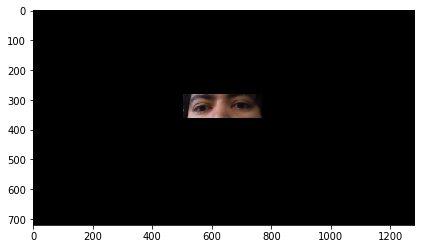

In [17]:
io.imshow(image_dr)

In [18]:
p00_image = io.imread(image_dr)

In [19]:
p00_image.shape # image size with black border

(720, 1280, 3)

In [20]:
from matplotlib import pyplot as plt

In [21]:
contour_points = eye_land_marks.iloc[0, :]

In [22]:
contour_points.shape

(24,)

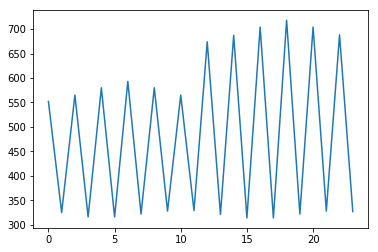

In [23]:
plt.plot(contour_points)

In [24]:
contour_points

0     552
1     325
2     565
3     316
4     580
5     316
6     593
7     322
8     580
9     328
10    565
11    329
12    674
13    321
14    687
15    314
16    704
17    314
18    718
19    322
20    704
21    328
22    688
23    327
Name: 0, dtype: int64

In [25]:
import numpy as np

In [26]:
x = np.reshape(contour_points, [12, 2])[:, 0]

/nfshome/xueqin/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


In [27]:
y = np.reshape(contour_points, [12, 2])[:, 1]

/nfshome/xueqin/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


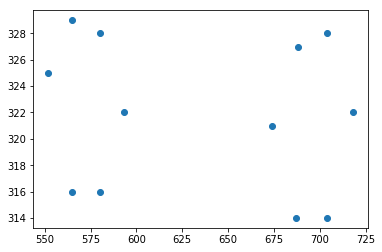

In [28]:
plt.plot(x ,y, 'o')

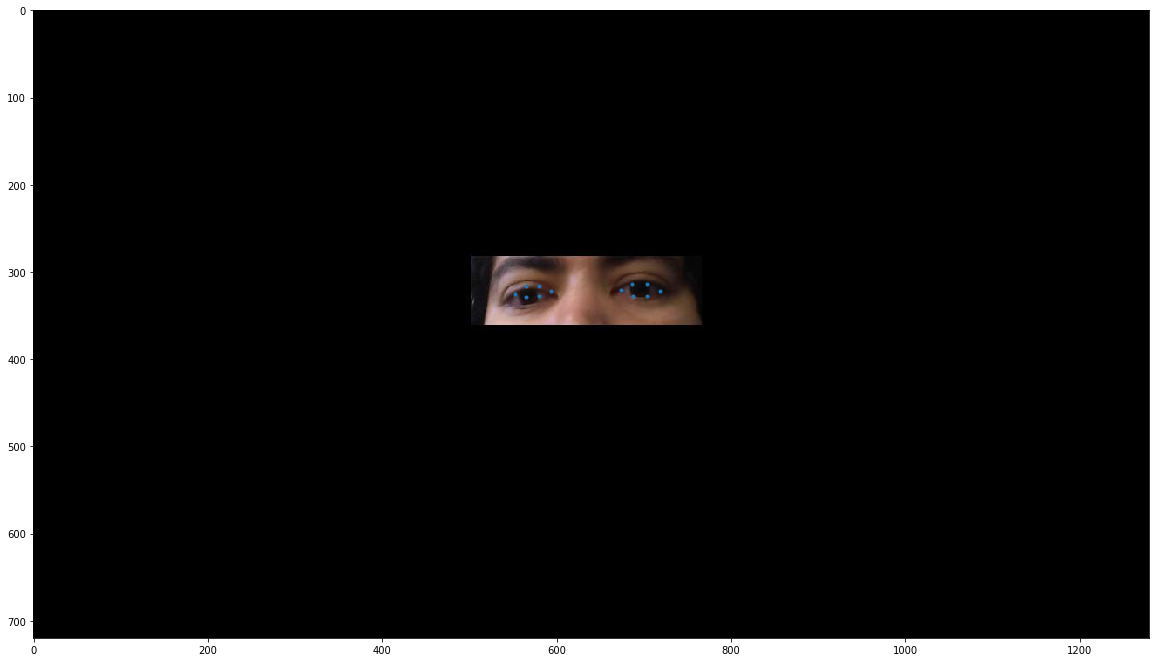

In [29]:
fig = plt.figure(figsize=(20, 30))
implot = plt.imshow(p00_image)
plt.plot(x, y, '.', )
plt.show()

In [30]:
from scipy import io

In [31]:
p00_d1 = io.loadmat('/nfshome/xueqin/deeplearning/gaze_estimation/data/MPIIGaze/Data/Normalized/p00/day01.mat')

In [32]:
p00_d1.keys()

dict_keys(['__header__', '__version__', '__globals__', 'data', 'filenames'])

In [33]:
p00_d1['data'][0][0][0][0][0][0].shape

(995, 3)

## define
1. Find out the data structure of mat file.

In [34]:
import numpy as np

In [35]:
# check shape of each layer in the p00_d1
def check_shape(file):
    return print(np.shape(file))

In [36]:
check_shape(p00_d1)

()


In [37]:
check_shape(p00_d1['data'])

(1, 1)


In [38]:
check_shape(p00_d1['data'][0])

(1,)


In [39]:
check_shape(p00_d1['data'][0][0])

()


In [40]:
check_shape(p00_d1['data'][0][0][0])

(1, 1)


In [41]:
check_shape(p00_d1['data'][0][0][0][0])

(1,)


In [42]:
check_shape(p00_d1['data'][0][0][0][0][0])

()


In [43]:
check_shape(p00_d1['data'][0][0][0][0][0][0])

(995, 3)


- The data is in 5 depth of the data set.

## define
draw the direction on image.

In [44]:
from glob import glob
pathname = '/nfshome/xueqin/deeplearning/gaze_estimation/data/MPIIGaze/Data/Original/p00/day01/'
import os
ori_im_dr = glob((os.path.join(pathname, '*.jpg'))) # original images derectories p00 day01.
# TODO return image path based on person and day and number.
def image_path(number):
    '''Return image path from number p00 day01
    Parameter: image number(int)
    return: path (str)'''
    
    pathname = '/nfshome/xueqin/deeplearning/gaze_estimation/data/MPIIGaze/Data/Original/p00/day01/'
    return glob((os.path.join(pathname, str(number)+'.jpg')))
image_path('001')

[]

In [45]:
# every line in the data is one direction of one image.
# make the image as the background and then draw 3d direction on the background.
# pick normalized data p00's first direction and first image.
directions_p00 = p00_d1['data'][0][0][0][0][0][0] # 3D directions array of 995 images in p00, day01, shape (995, 3)

normalized_images = skimage.io.imread(ori_im_dr[0])

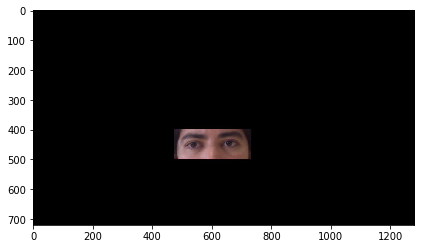

In [46]:
skimage.io.imshow(normalized_images)

## Define
1. Draw the direction in annotation.mat on corresponding original image.
    - Whether the annotation includes file address.
    - skiimage API to draw 3D derection and on specific background.

In [47]:
# check whether the path is in the annotation.txt
p00_d1.keys() # keys in one annotation file.

dict_keys(['__header__', '__version__', '__globals__', 'data', 'filenames'])

In [48]:
p00_d1['__header__']

b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Tue Jan 23 09:31:04 2018'

In [49]:
p00_d1['__version__']

'1.0'

In [50]:
p00_d1['__globals__']

[]

In [51]:
len(p00_d1['filenames']) # file name is in the filenames key.

995

1. The file name is including in the annotation file.

## Define 
1. key 'data' coorresponding to filename.

In [52]:
%pdb

Automatic pdb calling has been turned ON


In [53]:
# recursive function to extract data 
def recursive_check(data):
    if data is not None:
        if type(data) is np.ndarray:
            # print('type:',type(data))
            print(np.shape(data))
            recursive_check(data[0])
        elif type(data) is np.void:
            print(type(data))
            recursive_check(data[0])
        return 'done'
    return

In [54]:
recursive_check(p00_d1['data'])

(1, 1)
(1,)
<class 'numpy.void'>
(1, 1)
(1,)
<class 'numpy.void'>
(995, 3)
(3,)


'done'

In [55]:
p00_d1['data'][0][0][0][0][0]

(array([[-0.12202543,  0.09011014, -0.98842802],
       [-0.09933379,  0.21729911, -0.97103754],
       [-0.15406083,  0.15995623, -0.97502783],
       ..., 
       [ 0.0823537 ,  0.10323527, -0.99124182],
       [ 0.17156863,  0.11417502, -0.97853374],
       [-0.21271785,  0.23641129, -0.94808271]]), array([[[198, 210, 222, ...,  96, 102, 110],
        [210, 225, 238, ..., 110, 117, 120],
        [223, 232, 245, ..., 115, 123, 128],
        ..., 
        [234, 230, 232, ..., 249, 250, 250],
        [240, 237, 242, ..., 249, 249, 249],
        [247, 246, 249, ..., 249, 248, 249]],

       [[240, 245, 247, ...,  92, 100, 106],
        [242, 246, 246, ...,  95, 100, 110],
        [241, 245, 243, ..., 100, 103, 106],
        ..., 
        [254, 254, 253, ..., 253, 254, 252],
        [255, 255, 254, ..., 254, 253, 251],
        [255, 255, 254, ..., 255, 253, 251]],

       [[233, 241, 245, ...,  85,  88,  96],
        [236, 241, 244, ...,  91,  96, 105],
        [238, 241, 242, ...,  99, 

In [56]:
np.shape(p00_d1['data'][0][0][0][0][0][0]) # direction or not?

(995, 3)

In [57]:
np.shape(p00_d1['data'][0][0][0][0][0][1]) # image

(995, 36, 60)

In [58]:
np.shape(p00_d1['data'][0][0][0][0][0][2]) # 

(995, 3)

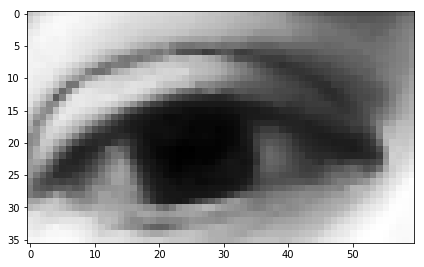

In [59]:
skimage.io.imshow(p00_d1['data'][0][0][0][0][0][1][0])

# Another dataset "It's all written on your face"

## Data gathering

[It's written all over your face data_url](https://www.mpi-inf.mpg.de/departments/computer-vision-and-multimodal-computing/research/gaze-based-human-computer-interaction/its-written-all-over-your-face-full-face-appearance-based-gaze-estimation/)

[original dataset](http://datasets.d2.mpi-inf.mpg.de/MPIIGaze/MPIIFaceGaze.zip)

[normalized dataset](http://datasets.d2.mpi-inf.mpg.de/MPIIGaze/MPIIFaceGaze_normalized.zip)

### Define
1. Difference between original dataset and normalized data set.
2. Original image whether is full face or not.
3. Calculate direction for every image.

In [80]:
# Difference between original and normalized data set.
# original data set derectory
original_dr = '/nfshome/xueqin/deeplearning/gaze_estimation/data/all_writte/MPIIFaceGaze/'
# data is in the p00/dayxx/xxx.jpg
# define a function with parameter person, day, and number of image.
def showIm2Nd(person, day, number, dr=original_dr):
    original_dr = '/nfshome/xueqin/deeplearning/gaze_estimation/data/all_writte/MPIIFaceGaze/'
    selectedIm = original_dr+'p{:02}/day{:02}/{:04}.jpg'.format(person, day, number)
    return selectedIm

In [81]:
showIm2Nd(1, 2, 3)

'/nfshome/xueqin/deeplearning/gaze_estimation/data/all_writte/MPIIFaceGaze/p01/day02/0003.jpg'

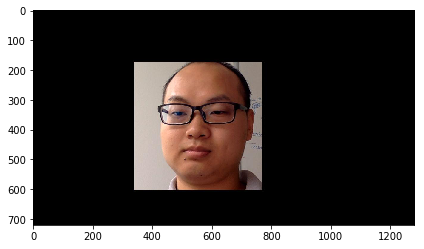

In [94]:
# test showIm2Nd
skimage.io.imshow(showIm2Nd(1,31,188))

In [89]:
# Calculate direction for every iamge.
# Annotation file and its meaning.
# Equation to calculate with Annotation file.
# Annotation file address
def annotationDr(person):
    'return annotation file for specific person.'
    original_dr = '/nfshome/xueqin/deeplearning/gaze_estimation/data/all_writte/MPIIFaceGaze/'
    return original_dr + 'p{:02}/p{:02}.txt'.format(person, person)

In [90]:
# test annotation directory function
annotationDr(1)

'/nfshome/xueqin/deeplearning/gaze_estimation/data/all_writte/MPIIFaceGaze/p01/p01.txt'

In [92]:
# Read annotation file.
pd.read_csv(annotationDr(1), delim_whitespace=True, header=)

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,day01/0005.jpg,1148,290,531,336,575,339,667,341,716,...,-3.017727,-7.797238,510.734022,-3.850668,13.833595,503.370462,-100.697473,72.552627,1.928007,right
1,day01/0009.jpg,710,875,553,352,599,357,690,361,739,...,7.983263,1.207748,502.547917,7.054004,23.848679,505.602992,-12.987360,188.235058,9.738599,left
2,day01/0010.jpg,1381,571,527,347,570,350,662,352,710,...,-5.450902,-2.497622,514.875381,-6.212678,19.452330,508.517075,-146.679054,128.210800,9.764388,left
3,day01/0011.jpg,236,385,575,337,622,341,715,345,760,...,19.287347,-6.209869,511.085647,18.304748,15.216538,503.164011,80.647908,91.165978,-4.549946,right
4,day01/0034.jpg,1300,382,477,364,528,372,637,385,693,...,-18.338706,9.217816,428.553126,-20.982602,31.919149,427.868970,-130.798429,90.790781,5.191165,right
5,day01/0037.jpg,92,3,541,350,597,358,705,366,755,...,9.289216,2.609041,431.747074,7.822991,25.205033,428.572157,108.827544,15.538031,-13.611567,right
6,day01/0038.jpg,17,758,547,374,603,382,713,393,767,...,12.041722,12.603641,424.111402,10.151025,35.389610,424.294801,124.594991,164.938265,0.985381,left
7,day01/0048.jpg,891,265,535,348,578,351,666,357,712,...,-3.043781,-0.625757,532.337815,-4.577929,22.186959,532.150387,-49.653846,67.552311,-0.945768,right
8,day01/0057.jpg,1413,609,527,355,569,358,657,364,703,...,-7.508427,2.895088,534.570122,-9.088571,25.664324,533.201252,-152.994798,135.737629,10.828637,left
9,day01/0063.jpg,1007,644,542,334,590,339,693,345,743,...,5.922545,-6.243916,458.421861,4.523189,16.319516,461.848535,-72.272625,142.580804,7.797163,left


1. The images in each person and files are not in sequensal.
2. What is the evaluation dataset used for.

### calculate every direction of the images

Dimension 1: image file path and name.

Dimension 2~3: Gaze location on the screen coordinate in pixels, the actual screen size can be found in the "Calibration" folder.

Dimension 4~15: (x,y) position for the six facial landmarks, which are four eye corners and two mouth corners.

Dimension 16~21: The estimated 3D head pose in the camera coordinate system based on 6 points-based 3D face model, rotation and translation: we implement the same 6 points-based 3D face model in [1], which includes the four eye corners and two mouth corners

Dimension 22~24 (fc): Face center in the camera coordinate system, which is averaged 3D location of the 6 focal landmarks face model. Not it is slightly different with the head translation due to the different centers of head and face.

Dimension 25~27 (gt): The 3D gaze target location in the camera coordinate system. The gaze direction can be calculated as gt - fc. 

Dimension 28: Which eye (left or right) is used for the evaluation subset in [2].

In [95]:
# calculate every direction of the images.
annotation_origin = pd.read_csv(annotationDr(1), delim_whitespace=True, header=None) # original annatation origin file of person 1.

In [97]:
# copy annotation origin
annotation_clean = annotation_origin.copy()

In [100]:
# Face center
face_center = annotation_clean.iloc[:, 22:25]

In [101]:
# test face center
face_center.describe()

,22,23,24
count,2904.000000,2904.000000,2904.000000
mean,8.287007,492.082951,-15.974298
std,33.333072,81.964558,82.666779
min,-384.213022,291.572766,-158.737803
25%,-8.988389,446.197021,-84.716772
50%,10.142596,486.475042,-17.497340
75%,27.133450,529.250170,54.132138
max,115.408792,1622.420788,127.720664


In [137]:
# gaze target
gt = annotation_clean.iloc[:, 24:27]

In [138]:
# test target
gt.describe()

,25,26,27
count,2904.000000,2904.000000,2904.000000
mean,-15.974298,102.070470,1.037562
std,82.666779,51.747285,6.588842
min,-158.737803,15.375111,-13.983979
25%,-84.716772,56.796423,-3.867364
50%,-17.497340,101.491324,0.968638
75%,54.132138,146.385273,5.999130
max,127.720664,193.036035,16.444951


In [142]:
# calculate gaze direction
gaze_direction = gt.values - face_center.values

In [143]:
gaze_direction.shape

(2904, 3)

## Define
1. Combine gaze estimation in the original table.
    - Append to the next three columns.
2. Draw direction on the image.

In [ ]:
an